In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Stark_ML' already exists and is not an empty directory.
patching file abstract_model.py
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
5 out of 5 hunks ignored -- saving rejects to file abstract_model.py.rej
patching file multitask.py
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
2 out of 2 hunks ignored -- saving rejects to file multitask.py.rej
patching file pretraining.py
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
3 out of 3 hunks ignored -- saving rejects to file pretraining.py.rej
patching file tab_model.py
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file tab_model.py.rej
patching file tab_netwo

In [2]:
import os

!pip install optuna
!pip install catboost
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
import importlib

torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [3]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

#!!!
#!!!
#!!!
#Don't gorget to change branch
!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

In [6]:
FIG_SMALL = (3.375, 3.375)
FIG_LARGE = (6.75, 3.375)

In [7]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )

# Figure 1. Width histogram

In [ ]:
elements_to_exclude = ['S', 'Mg', 'Mn']
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
data_test_q4, target_test_q4 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 75,
                                              random_state = 6)

d1 = pd.concat([target_width[target_width <= target_width.describe()['25%']].reset_index(),
                pd.Series(np.full(shape=len(target_width[target_width <= target_width.describe()['25%']]), fill_value='Train'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
d2 = pd.concat([target_test_q1.reset_index(),
                pd.Series(np.full(shape=len(target_test_q1), fill_value='Test'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
q1 = pd.concat([d1, d2], axis = 0, ignore_index=True)

d1 = pd.concat([target_width[target_width > target_width.describe()['75%']].reset_index(),
                pd.Series(np.full(shape=len(target_width[target_width > target_width.describe()['75%']]), fill_value='Train'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
d2 = pd.concat([target_test_q4.reset_index(),
                pd.Series(np.full(shape=len(target_test_q4), fill_value='Test'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
q4 = pd.concat([d1, d2], axis = 0, ignore_index=True)

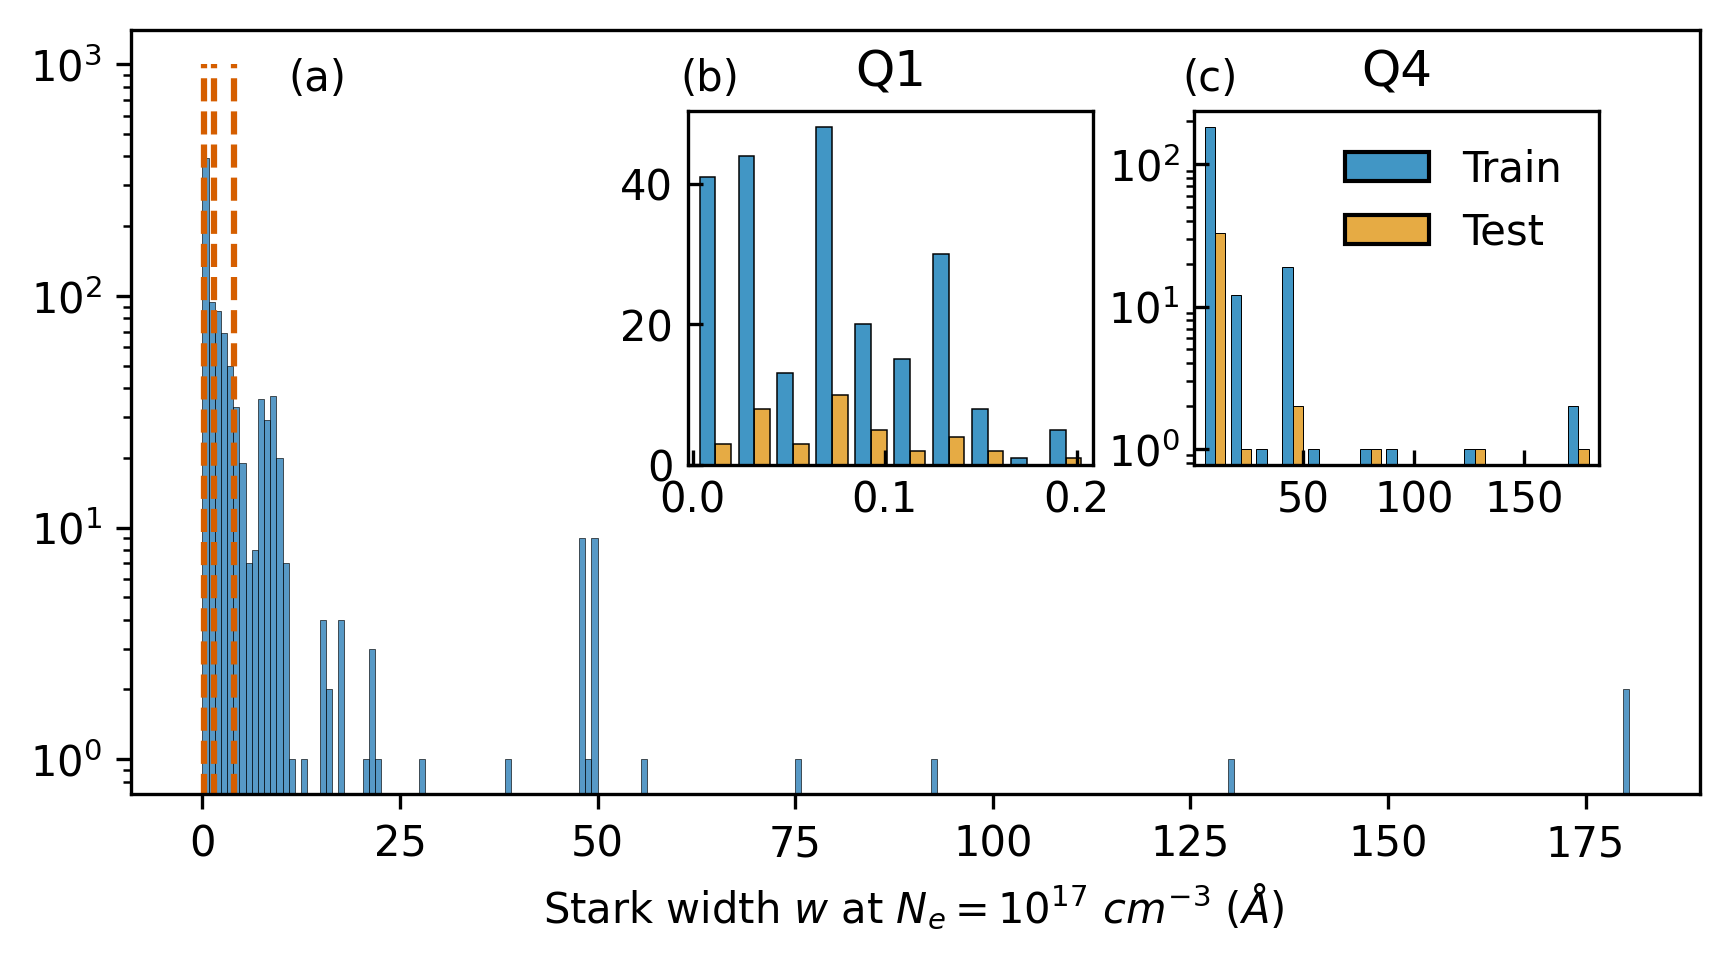

In [ ]:
sns.color_palette('gray')

fig, ax = plt.subplots(figsize = FIG_LARGE, dpi = 300)
#n, bins, patches = plt.hist(data['w (A)'], bins='auto', log=True, rwidth = 0.8)
sns.histplot(data = data, x = data['w (A)'], ax = ax, log_scale = (False, True), palette = 'colorblind')
ax.vlines(x = data['w (A)'].describe()['25%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')
ax.vlines(x = data['w (A)'].describe()['50%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')
ax.vlines(x = data['w (A)'].describe()['75%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')

ax.set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ')
ax.set_ylabel(None)

ax_in1 = fig.add_axes([0.4, 0.45, 0.20, 0.35])
#ax_in1.axes.yaxis.set_ticklabels([])
ax_in2 = fig.add_axes([0.65, 0.45, 0.20, 0.35])
#ax_in2.axes.yaxis.set_ticklabels([])

ax_in1.set_title('Q1')
ax_in2.set_title('Q4')

sns.histplot(data = q1, x = 'w', hue = 'Type', multiple="dodge", shrink=.8, ax = ax_in1, palette = 'colorblind')
sns.histplot(data = q4, x = 'w', hue = 'Type', multiple="dodge", shrink=.8, ax = ax_in2, bins = 15, log_scale = (False, True), palette = 'colorblind')
ax_in2.get_legend().set_title(None)
ax_in2.get_legend().set_frame_on(False)
ax_in1.get_legend().remove()
ax_in1.set(ylabel = None)
ax_in2.set(ylabel = None)
ax_in1.set(xlabel = None)
ax_in2.set(xlabel = None)
ax_in1.tick_params('both', direction = 'in')
ax_in2.tick_params('both', direction = 'in')
ax_in1.set_xlim(target_width.describe()['min'] - 0.02 * (target_width.describe()['25%'] - target_width.describe()['min']),
                target_width.describe()['25%'] + 0.02 * (target_width.describe()['25%'] - target_width.describe()['min']))
ax_in2.set_xlim(target_width.describe()['75%'] - 0.02 * (target_width.describe()['max'] - target_width.describe()['75%']),
                target_width.describe()['max'] + 0.02 * (target_width.describe()['max'] - target_width.describe()['75%']))
ax.text(x = 0.1, y = 0.92, s = '(a)', transform = ax.transAxes)
ax.text(x = 0.35, y = 0.92, s = '(b)', transform = ax.transAxes)
ax.text(x = 0.67, y = 0.92, s = '(c)', transform = ax.transAxes)

plt.show()

fig.savefig('D:\\Laboratory\\Papers\\Physical Review Letters\\Paper 2022\\Figures\\Fig.1.Colorblind.svg', transparent = True, format = 'svg')

In [ ]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [ ]:
sns.color_palette('colorblind').as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

# Figure 2. Elements pie chart

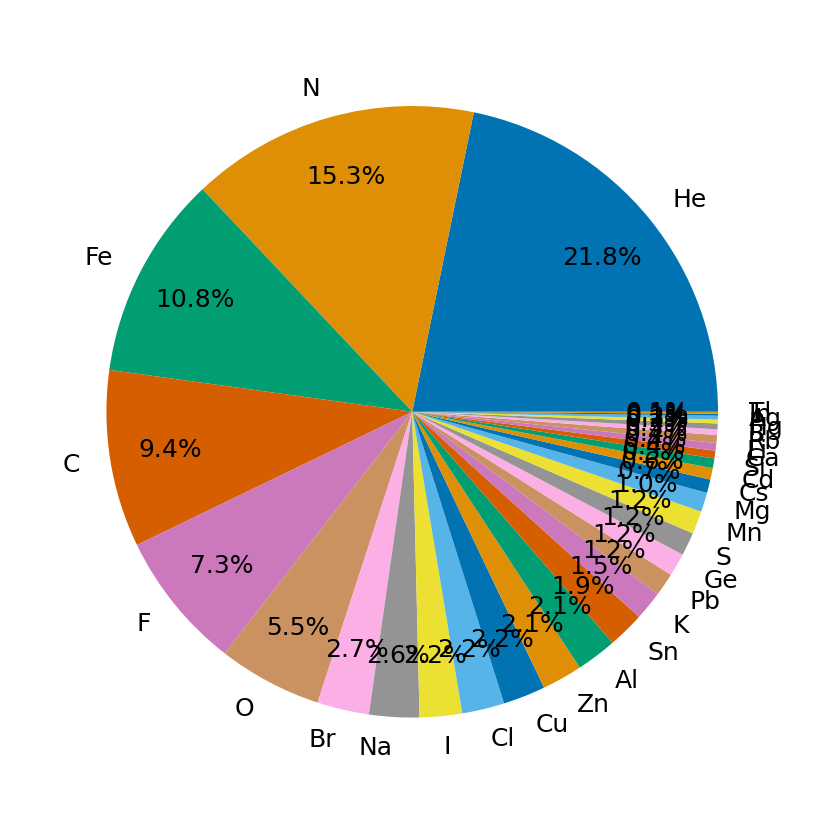

In [ ]:
new_rc_params = {'text.usetex': False,
                "svg.fonttype": 'none'
                }
plt.rcParams.update(new_rc_params)


fig, ax = plt.subplots(figsize = FIG_SMALL, dpi = 300)

ax.pie(data['Element'].value_counts(), labels = data['Element'].value_counts().index, colors = sns.color_palette('colorblind'), autopct = '%.1f%%', labeldistance = 1.1, pctdistance = 0.8, textprops = {'size' : 6})

plt.show()

fig.savefig('Fig.2.Pie chart. Colorblind.svg', transparent = True, format = 'svg')

# Figure 3. 

In [47]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )

data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Step 2.
#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Step 3.
#Split into train and test
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

#Step 4.
factor = 1.05
data_width_train_extended = data_width_train
target_width_train_extended = target_width_train
for index, row in data_width_train.iterrows():
    row['T'] = row['T']*factor
    data_width_train_extended = data_width_train_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_train_extended = target_width_train_extended.append(pd.Series(target_width_train.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_train_extended = data_width_train_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_train_extended = target_width_train_extended.append(pd.Series(target_width_train.loc[index]), ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


In [48]:
#@title Use extended train set?
extended_train_set = False#@param {type:"boolean"}

#Assigning proper variables
if extended_train_set:
    XW_train, YW_train = data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train_extended
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
else:
    XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

(743, 50) (743,)
(154, 50) (154,)

 (743, 50) (743,)
(154, 50) (154,)


In [49]:
#@title Max width value
#@markdown You can enter any reasonable value less than 180 Angstrom.
width_threshold =  200#@param {type:"number"}

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

In [50]:
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]

if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)

Getting KNN predictions
Getting XGB predictions
[13:14:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Plotting KNN predictions
Plotting XGB predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


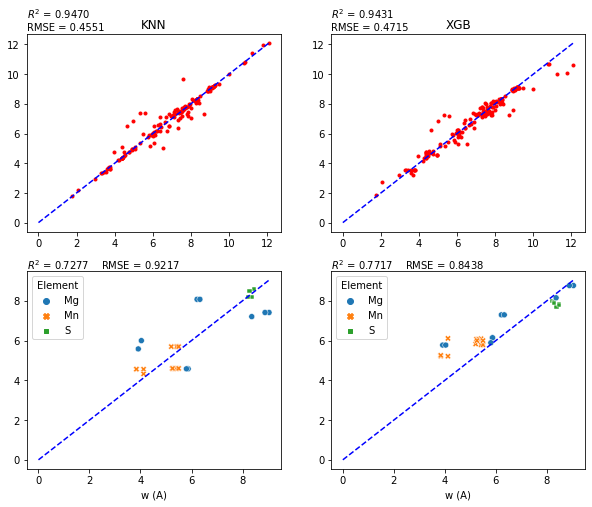

In [51]:
models = ['KNN', 'XGB']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

In [53]:
if scaled_target:
    YW_train = (np.exp(YW_train) - 1) * epsilon
    YW_test = (np.exp(YW_test) - 1) * epsilon
    YW_elem = (np.exp(YW_elem) - 1) * epsilon
    for name, values in preds.items():
        preds[name] = (np.exp(preds[name]) - 1) * epsilon
        preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon
    scaled_target = False

Plotting KNN predictions
Plotting XGB predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


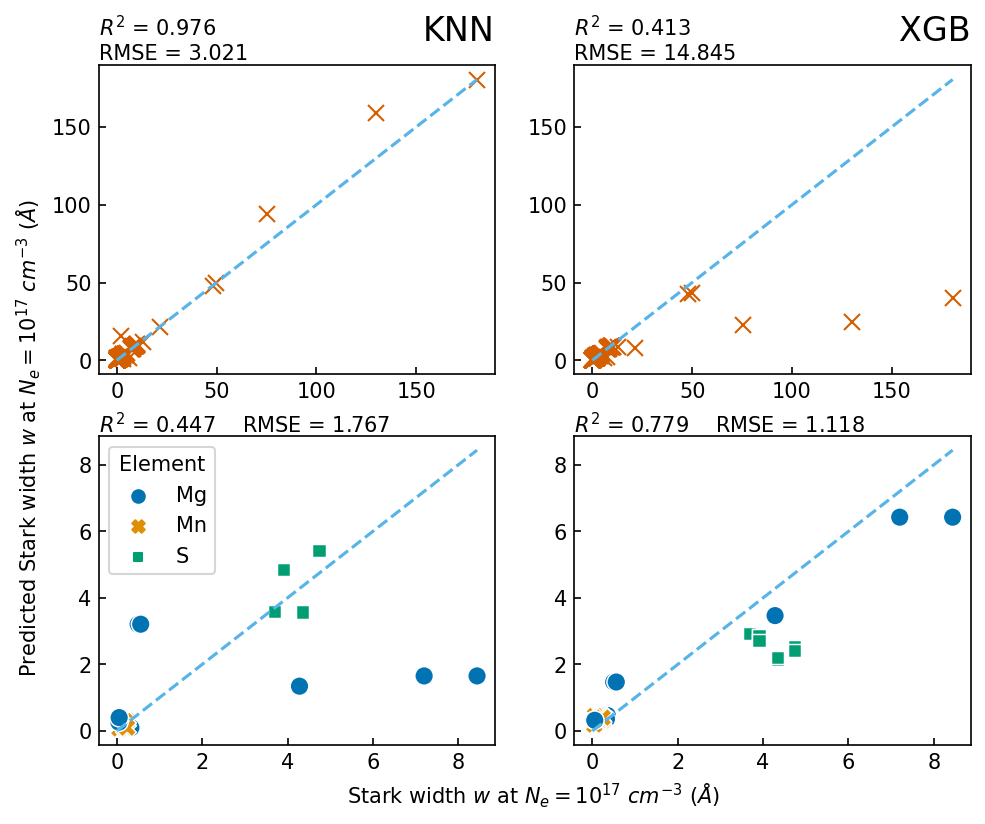

In [55]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 16, pad = 12, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(YW_elem, preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2)
plt.show()

#fig.savefig('Fig.3b.Predicted-reference. Scaled.svg', transparent = True, format = 'svg')

In [85]:
type(plt.get_cmap('gray'))

matplotlib.colors.LinearSegmentedColormap

In [86]:
type(sns.color_palette('colorblind'))

seaborn.palettes._ColorPalette